## Setup

In [1]:
import json as js
from importlib import reload

import pickle
import pandas as pd
import numpy as np
from pprint import pprint
from urllib.parse import urlparse

import utils 
%matplotlib inline

In [2]:
configvars = utils.get_configs()

## Read datasets

In [3]:
base_df = utils.read_base_dataset("malicious-urls")
base_df.head()

,URL,Label
0,http://astore.amazon.co.uk/allezvinsfrenchr/de...,Spam
1,http://archive.salisburyjournal.co.uk/2007/3/6...,Spam
2,http://appbasic.jettons.co.uk/links/index.html,Spam
3,http://archive.yorkpress.co.uk/2003/11/6/25684...,Spam
4,http://acard4u.co.uk/product_reviews.php?cPath...,Spam


In [4]:
X, y = base_df['URL'], base_df['Label']

In [5]:
y.value_counts(normalize=True)

Defacement    0.583294
Benign        0.213938
Spam          0.072566
Malware       0.069942
Phishing      0.060260
Name: Label, dtype: float64

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import re

def custom_tokenizer(string):
    final = []
    tokens = [a for a in list(urlparse(string)) if a]
    for t in tokens:
        final.extend(re.compile("[.-]").split(t))
    return final
print (custom_tokenizer('google.com'))
print(custom_tokenizer('https://google-so-not-fake.com?fake=False&seriously=True'))

['google', 'com']
['https', 'google', 'so', 'not', 'fake', 'com', 'fake=False&seriously=True']


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split

# Structure of Model
vect = CountVectorizer(tokenizer=custom_tokenizer)
rc = RidgeClassifier()
rc_pipe = Pipeline([('vect', vect), ('model', rc)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)



In [8]:
# Uncomment to Train Model
rc_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function custom_tokenizer at 0x7f5ec83d0430>)),
                ('model', RidgeClassifier())])

In [10]:
model_path = "countvectorizer-ridgeregression-pipeline.pkl"
# utils.save_model(rc_pipe, model_path)
# Uncomment to Write to Pickle File
# with open(model_path, "wb") as file:
#     pickle.dump(rc_pipe, file)


Saved model at : models/mmm.pkl


In [13]:
# Read Pickled Model File
rc_pipe = utils.load_model("iscxurls_ridgeclassifier")

In [14]:
# Transforming a parsel_url list
parsed_url = ['https', 'google', 'so', 'not', 'fake', 'com', 'fake=False&seriously=True']
url_vector = rc_pipe['vect'].transform(parsed_url).toarray()

In [15]:
y_predict = rc_pipe.predict(X_test)

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10536
  Defacement       0.98      1.00      0.99     29080
     Malware       1.00      0.99      1.00      3462
    Phishing       0.99      0.84      0.91      3038
        Spam       1.00      1.00      1.00      3494

    accuracy                           0.99     49610
   macro avg       0.99      0.97      0.98     49610
weighted avg       0.99      0.99      0.99     49610



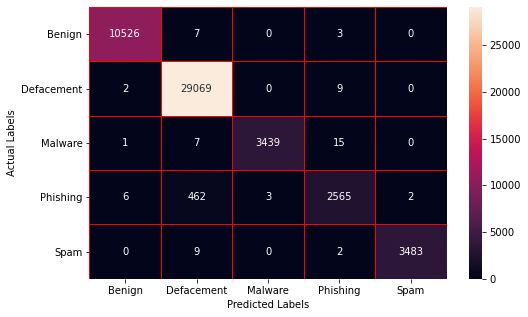

In [16]:
import utils
reload(utils)
classes = rc_pipe['model'].classes_
utils.get_scores_plots_stats(y_test, y_predict, multiclass_avg=None, class_labels=classes, figsize=(8,5))

## Investigating Misclassification

In [16]:
pred_test_df = pd.DataFrame(X_test)
pred_test_df[['Actual']] = y_test
pred_test_df[['Predicted']] = y_predict
pred_test_df


,URL,Actual,Predicted
36913,http://elitedaily.com/entertainment/time-makeo...,Benign,Benign
150984,http://www.ekadana.com/genesis-videography.html,Defacement,Defacement
125638,http://www.planet-fitness.it/index.php?option=...,Defacement,Defacement
21771,http://bjpgqsc.com/gwzh/class/?0.html&page=2&s...,Malware,Malware
161546,http://www.radioroccella.net/index.php?option=...,Defacement,Defacement
...,...,...,...
18028,http://www.xwjy.org/tresearch/UserFiles/00002/...,Malware,Malware
55534,http://tobogo.net/cdsb/board.php?board=storyan...,Benign,Benign
102693,http://www.viaggiareinirlanda.net/itinerari/wa...,Defacement,Defacement
94722,http://www.hostrat.com/index.php?option=com_ma...,Defacement,Defacement


In [17]:
misclassified_samples = pred_test_df.query('Actual != Predicted')
correctly_labeled_samples = pred_test_df.query('Actual == Predicted')

worst_classified = misclassified_samples.groupby(["Actual", "Predicted"]).count().reset_index()
worst_classified.sort_values('URL', ascending=False)

,Actual,Predicted,URL
8,Phishing,Defacement,462
6,Malware,Phishing,15
3,Defacement,Phishing,9
11,Spam,Defacement,9
0,Benign,Defacement,7
5,Malware,Defacement,7
7,Phishing,Benign,6
1,Benign,Phishing,3
9,Phishing,Malware,3
2,Defacement,Benign,2


### Investigate the first 3 worst offences
1. Phishing with Defacement
2. Malware with Phishing
3. Defacement with Phishing

In [20]:
actual_label = "Phishing"
false_label = "Defacement"
max_num_of_samples = 9

print(f"`{actual_label}` Samples\n")
sel = (correctly_labeled_samples.Actual == actual_label)
print(correctly_labeled_samples[sel].URL.values[:max_num_of_samples])

print(f"\n\n ...and samples misclassified as `{false_label}`\n")
sel_group = (misclassified_samples.Actual == actual_label) & (misclassified_samples.Predicted == false_label)
print(misclassified_samples[sel_group].URL.values[:max_num_of_samples])

`Phishing` Samples

['http://www.pirazzoliwines.com/wp-admin/cgi-bin/2294816c33de85d60b9ea3d40ea81b67/login_verify2_email.htm'
 'http://www.frampton.co/Login/Home/update/websc-carding.php'
 'http://getir.net/05ky#%20%280.007849624383792441761897862306796014308929443359375000000000%29?0.75942.0.62930.0.58543'
 'http://www.traducator-iasi.ro/wp-includes/images/smilies/-/4546546556456PkKKQD564654654634SD54DSF51SDF46S6QSDQ8SQ4D51QS5D4Q65S1DQS56D4QS5D4QSD1Q35S4DQ65S3D1Q35SD2Q/840ef17a235fb0b7649921508700a2a9/'
 'http://izillis.biz/hdlu9nx8qvT1cay47343/92vjs8gr7xbelT6mcNdxDE74640/sdr01/bWFuZnJlZC5oZWluZW5AdC1vbmxpbmUuZGUMessage-ID:'
 'http://host109-157-149-231.range109-157.btcentralplus.com/sec/'
 'http://ebay.co.uk.ebsasdertysader.ns360.info/'
 'http://online.citi.com.m6tysyavnym49os52xmhjgam1b2cwl.bucspray.gr/slow/online.php'
 'http://www.happymoviesite.com/wp-admin/outluk/neww.html']


 ...and samples misclassified as `Defacement`

['http://dittberner.com/images/topbargreenish/4214921583